In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import sys
sys.path.append("/home/mylab-pharma/Code/tuele/pan_HDAC/mylab_panHDAC-master/src/common")
from pharmacy_common import PharmacyCommon

#class to encode smiles
common = PharmacyCommon()

In [2]:
train_dataset = pd.read_excel('../../data/train_test_data/NoCL/20240321_pan_HDAC_train_test_data.xlsx',sheet_name='train_dataset')
validation_dataset = pd.read_excel("../../data/train_test_data/NoCL/20240321_pan_HDAC_train_test_data.xlsx", sheet_name='validation_dataset')
test_dataset = pd.read_excel("../../data/train_test_data/NoCL/20240321_pan_HDAC_train_test_data.xlsx", sheet_name='test_dataset')
print(len(train_dataset),len(validation_dataset), len(test_dataset))

1528 328 327


In [3]:
train_dataset.head(10)

,Code,SMILES,Bioactivity
0,415897,CC(Nc1ccc(CN(CCC=C2CCC(NO)=O)C2=O)cc1)=O,inactive
1,1589183,COc(cc(/C=C/C(Nc(cccc1)c1N)=O)cc1)c1OCC(Nc(cc1...,inactive
2,1161066,CC[C@H](C)[C@@H](C(N(Cc1c(C2)ccc(OCC(NO)=O)c1)...,active
3,2100074,CC(c1ccccc1)Nc1ncnc2c1cc(-c1ccc(CN3CCN(CCOCCCC...,inactive
4,386804,CC(C)SC(SCC(c1ccc(C)cc1)=O)=S,inactive
5,467667,CCOC(SCC(c(cc1)ccc1NC(C)=O)=O)=S,inactive
6,390739,ONC(/C=C/c1cccc(C(c2cc(cccc3)c3[nH]2)=O)c1)=O,active
7,440474,ONC(CCCCCNC(Nc1cc(-c2nc(cccc3)c3[o]2)ccc1)=O)=O,active
8,2460036,CN1C(SCc(cc2)ccc2C(Nc(cccc2)c2N)=O)=Nc(cc(cc2)...,inactive
9,440227,CCC(c1nc(cccc2)c2[n]1CC)c1ccc(/C=C/C(NO)=O)cc1,active


In [4]:
#encoding smiles 
fpt_bits = 1024
X_train = common.gen_ecfp4_fpts(train_dataset['SMILES'],bits = 1024)
X_validation = common.gen_ecfp4_fpts(validation_dataset['SMILES'], bits = 1024)
X_test = common.gen_ecfp4_fpts(test_dataset['SMILES'], bits = 1024)

Progress:   0%|          | 0/1528 [00:00<?, ?it/s][10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04:25] DEPRECATION WARNING: please use MorganGenerator
[10:04

In [5]:
# encoding the label
import sklearn.preprocessing as preprocessing
y_train = np.array(train_dataset['Bioactivity'])
y_validation = np.array(validation_dataset['Bioactivity'])
y_test = np.array(test_dataset['Bioactivity'])

#Original data
print("Original data:")
print(y_train[0:5])
print(y_test[0:5])
print(y_validation[0:5])

#label encoding
label_encoder = preprocessing.LabelEncoder()
y_train  = label_encoder.fit_transform(y_train)
y_validation = label_encoder.fit_transform(y_validation)
y_test = label_encoder.fit_transform(y_test)
#Class encoded
print("Class encoded:")
print(list(label_encoder.classes_))
print(label_encoder.transform(label_encoder.classes_))
print("Encoded data:")
print(y_train[0:5])
print(y_test[0:5])
print(y_validation[0:5])

Original data:
['inactive' 'inactive' 'active' 'inactive' 'inactive']
['active' 'active' 'active' 'inactive' 'active']
['active' 'active' 'inactive' 'inactive' 'inactive']
Class encoded:
['active', 'inactive']
[0 1]
Encoded data:
[1 1 0 1 1]
[0 0 0 1 0]
[0 0 1 1 1]


In [6]:
#converting to tensor 
X_train_df = pd.DataFrame(X_train)
X_validation_df = pd.DataFrame(X_validation)
X_test_df = pd.DataFrame(X_test)

X_train = torch.tensor(X_train_df.values, dtype=torch.float32)
X_validation = torch.tensor(X_validation_df.values, dtype=torch.float32)
X_test = torch.tensor(X_test_df.values, dtype=torch.float32)

y_train_df = pd.DataFrame(y_train)
y_validation_df = pd.DataFrame(y_validation)
y_test_df = pd.DataFrame(y_test)

y_train = torch.tensor(y_train_df.values, dtype=torch.float32)
y_validation = torch.tensor(y_validation_df.values, dtype=torch.float32)
y_test = torch.tensor(y_test_df.values, dtype=torch.float32)

In [7]:
y_train

tensor([[1.],
        [1.],
        [0.],
        ...,
        [0.],
        [1.],
        [1.]])

In [8]:
# model
class ann_try(nn.Module):
    def __init__(self, input_dim=1024,layer1=512,layer2=256,drp=.2,output=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,layer1),
            nn.ReLU(),
            nn.Dropout(drp),
            nn.Linear(layer1,layer2),
            nn.ReLU(),
            nn.Dropout(drp),
            nn.Linear(layer2,output),
            nn.Sigmoid(),
        )
    def forward(self,input):
        return self.net(input)

In [9]:
# trainning
def training(x_train = X_train,y_train=y_train,x_validation = X_validation,
            #  y_validation = y_validation,lr=0.001,l2=0.001,batch_size=64,epochs=100):
            y_validation = y_validation,lr=0.007206041689487159,l2=0.004176049826978714,batch_size=128,epochs=500):
    torch.manual_seed(0)
    losses=[]
    
    data_train = x_train
    labels_train = y_train
    #double train dataset
    # data_train   = torch.cat((x_train,x_train),axis=0)
    # labels_train = torch.cat((y_train,y_train),axis=0)
    
    train_ds = TensorDataset(data_train, labels_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    model = ann_try()
    loss_func = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=l2)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        if epoch==0 or  epoch % 2 == 0:
            print(loss)
        losses.append(loss)
    losses_tensor = torch.tensor(losses)
    plt.title("Loss in training")
    plt.xlabel('Numepoch')
    plt.ylabel('Loss_value')
    plt.plot(losses_tensor.detach())
    
    model.eval()
    y_pred_train = model(x_train)>.5
    acc_train = 100*torch.mean((y_pred_train == y_train).float())
    y_pred = model(x_validation)>.5
    acc_val = 100*torch.mean((y_pred == y_validation).float())

    # mse = mean_squared_error(model(x_validation).detach().numpy(),y_.detach().numpy())
    print('Accuracy on validation set:' ,acc_train)
    print('Accuracy on validation set:' ,acc_val)

    return acc_train, acc_val, len(train_dl) #to specify what to maximize in this function

tensor(0.5704, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4182, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3085, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2331, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2425, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3194, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2256, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2281, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1784, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1733, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2009, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1981, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2442, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2690, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1845, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1430, grad_fn=<Bina

(tensor(97.8403), tensor(81.4024), 12)

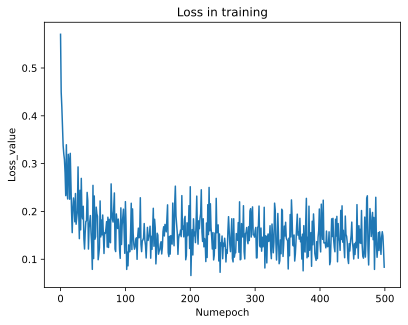

In [10]:
training(X_train,y_train,X_validation,y_validation)